In [1]:
# --- Qiskit Runtime & Providers ---
# The old IBMQ provider is replaced by QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService
# --- Simulators & Noise (from the separate qiskit-aer package) ---
# 'qiskit.Aer' and 'qiskit.providers.aer' are now 'qiskit_aer'
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
)
from qiskit_aer import Aer
from qiskit_aer.primitives import Estimator
# --- Core Algorithms & Primitives ---
# Primitives are the new way to interface with algorithms and backends
#from qiskit.primitives import StatevectorEstimator as Estimator
# VQE and NumPyMinimumEigensolver are in the new algorithms path
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

# --- Qiskit Nature (replaces qiskit.chemistry) ---
# PySCFDriver is now part of qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver
# FermionicOp is the modern replacement for FermionicOperator
from qiskit_nature.second_q.operators import FermionicOp
# Mappers are used to convert from fermionic to qubit operators
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit.circuit.library import EfficientSU2
# --- Circuit Library & Ansatze ---
# UCCSD and HartreeFock initial state are now in qiskit_nature
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
# Standard ansatz circuits
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# --- Utilities ---
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

your_api_key = "jemM0kHSznJ_FORY4ZSA29DltHfPyK37DZUr8NCV0MPU"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/c97832bb78c34a759e3d5a26a08911f5:7abec83f-1142-46a0-bb7b-5bae9f5e397b::"

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Qiskit Summer School Final Project: VQE

#### For this optional final challenge, you will be designing your own implementation of a variational quantum eigensolver (VQE) algorithm that simulates the ground state energy of the Lithium Hydride (LiH) molecule. Through out this challenge, you will be able to make choices on how you want to compose your simulation and what is the final deliverable that you want to showcase to your classmates and friends.

# Defining your molecule:
In this challenge we will focus on LiH using the sto3g basis with the PySCF driver, which can be described in Qiskit as follows, where 'inter_dist' is the interatomic distance.

In [3]:
inter_dist = 1.6

In [4]:
#driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=DistanceUnit.ANGSTROM, charge=0, spin=0, basis='sto3g')

We also setup the molecular orbitals to be considered and can reduce the problem size when we map to the qubit Hamiltonian so the amount of time required for the simulations are reasonable for a laptop computer.

In [5]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

#### Once you have computed the qubit operations for LiH, you can use the following function to classical solve for the exact solution. This is used just to compare how well your VQE approximation is performing.

In [6]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

Here we ask you to use the `statevector_simulator` as the simulation backend for your VQE algorithm.

In [7]:
backend = Aer.get_backend('statevector_simulator')

### Now you can start choosing the components that make up your VQE algorithm!

#### 1. Optimizers
The most commonly used optimizers are `COBYLA`, `L_BFGS_B`, `SLSQP` and `SPSA`. 

#### 2. Qubit mapping
There are several different mappings for your qubit Hamiltonian, `parity`, `bravyi_kitaev`, `jordan_wigner`, which in some cases can allow you to further reduce the problem size.

#### 3. Initial state
There are different initial state that you can choose to start your simulation. Typically people choose from the zero state 
`init_state = Zero(qubitOp.num_qubits)` 
and the UCCSD initial state
`HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, qubit_reduction)`

#### 4. Parameterized circuit
There are different choices you can make on the form of variational forms of your parameterized circuit.

`UCCSD_var_form = UCCSD(num_qubits, depth=depth, num_orbitals=num_spin_orbitals, num_particles=num_particles)`
    
`RY_var_form = RY(num_qubits, depth=depth)`
    
`RYRZ_var_form = RYRZ(num_qubits, depth=depth)`
    
`swaprz_var_form = SwapRZ(num_qubits, depth=depth)`

#### 5. Simulation backend
There are different simulation backends that you can use to perform your simulation

`backend = BasicAer.get_backend('statevector_simulator')`

`backend=Aer.get_backend('qasm_simulator')`

### Compare the convergence of different choices for building your VQE algorithm

Among the above choices, which combination do you think would out perform others and give you the lowest estimation of LiH ground state energy with the quickest convergence? Compare the results of different combinations against each other and against the classically computed exact solution at a fixed interatomic distance, for example `inter_dist=1.6`. 

To access the intermediate data during the optimization, you would need to utilize the `callback` option in the VQE function:

`def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)`
            
`algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)`

`algo_result = algo.run(quantum_instance)`

An example of comparing the performance of different optimizers while using the RY variational ansatz could like the following:
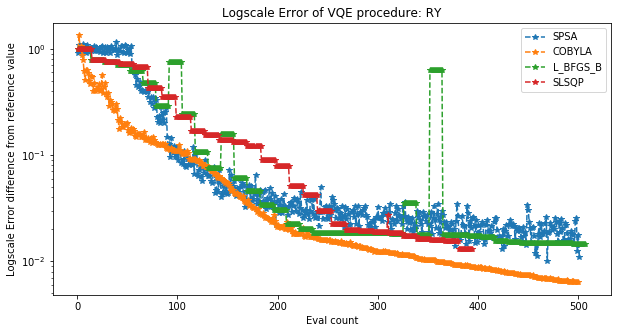
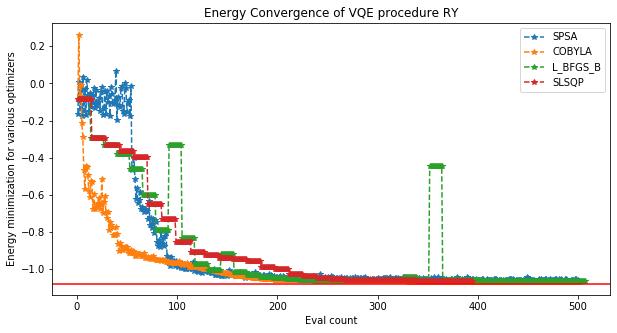

### Compute the ground state energy of LiH at various different interatomic distances
By changing the parameter `inter_dist`, you can use your VQE algorithm to calculate the ground state energy of LiH at various interatomic distances, and potentially produce a plot as you are seeing here. Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.
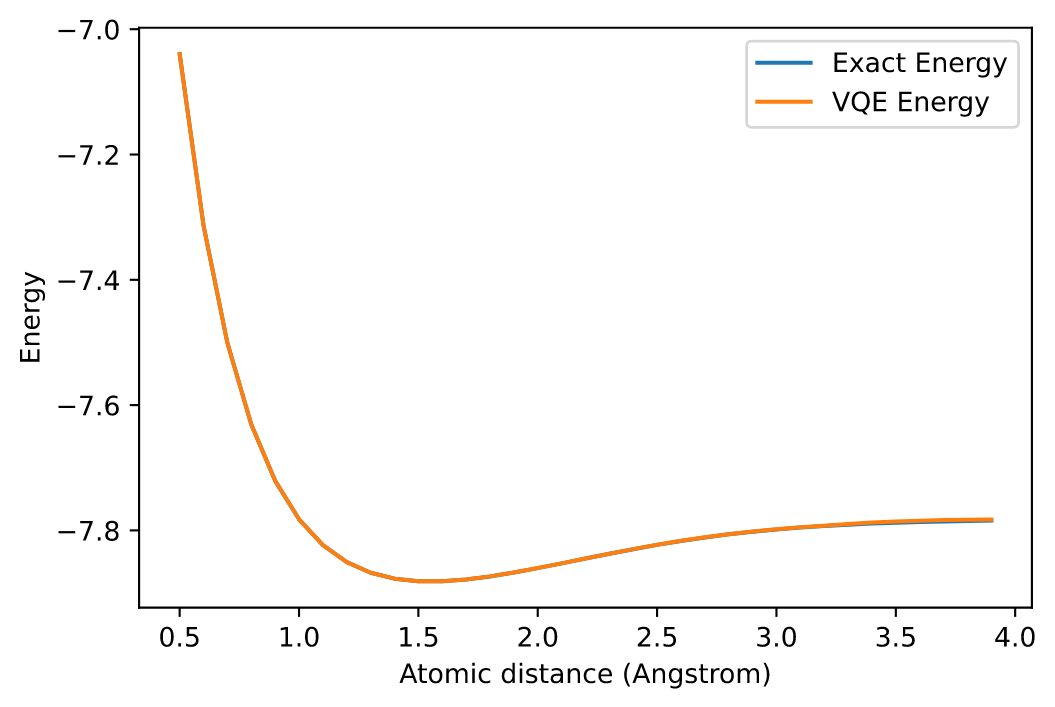

### How does your VQE algorithm perform in the presence of noise?
Trying importing the noise model and qubit coupling map of a real IBM quantum device into your simulation. You can use the imported noise model in your simulation by passing it into your quantum instance. You can also try enabling error mitigation in order to lower the effect of noise on your simulation results.

In [8]:
# Save your API key and crn and have access to the quantum computers
your_api_key = "jemM0kHSznJ_FORY4ZSA29DltHfPyK37DZUr8NCV0MPU"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/c97832bb78c34a759e3d5a26a08911f5:7abec83f-1142-46a0-bb7b-5bae9f5e397b::"

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)

In [9]:
# Check that the account has been saved properly
service = QiskitRuntimeService()
service.saved_accounts()

{'default-ibm-cloud': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'jemM0kHSznJ_FORY4ZSA29DltHfPyK37DZUr8NCV0MPU',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/c97832bb78c34a759e3d5a26a08911f5:7abec83f-1142-46a0-bb7b-5bae9f5e397b::',
  'verify': True,
  'private_endpoint': False}}

In [10]:
#Define our noise model based on the ibmq_essex chip
device = service.least_busy(simulator=False, min_num_qubits=5, operational=True)
print(f"Using device: {device.name}")
noise_model = NoiseModel.from_backend(device)
coupling_map = device.coupling_map
basis_gates = noise_model.basis_gates
backend = AerSimulator(noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)

Using device: ibm_torino


An example of comparing the energy convergence of using SPSA and COBYLA with the ibmq_essex noise model could look like the following
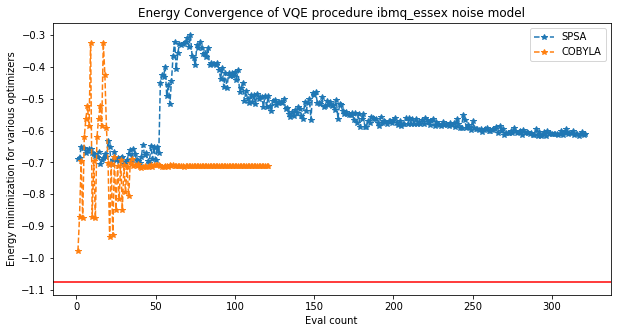

### Now given the choices you have made above, try writing your own VQE algorithm in Qiskit. You can find an example of using Qiskit to simuate molecules with VQE [here](https://qiskit.org/textbook/ch-applications/vqe-molecules.html).

In [11]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubit_op):
    """Classically solves for the exact ground state energy."""
    solver = NumPyMinimumEigensolver()
    result = solver.compute_minimum_eigenvalue(qubit_op)
    ref = result.eigenvalue
    print(f'Reference value: {ref:.6f}')
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=DistanceUnit.ANGSTROM, charge=0, spin=0, basis=basis)

    problem = driver.run()
    # The integrals are now part of the hamiltonian attribute
    electronic_integrals = problem.hamiltonian.electronic_integrals
    #h1 = electronic_integrals.one_body.get_matrix()
    #h2 = electronic_integrals.two_body.get_matrix()
    
    # Other properties are also accessed from the problem object
    nuclear_repulsion_energy = problem.hamiltonian.nuclear_repulsion_energy
    num_particles = problem.num_particles # This is a tuple (alpha_electrons, beta_electrons)
    num_spin_orbitals = problem.num_spatial_orbitals * 2
    
    print("HF energy: {}".format(problem.reference_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # 2. Simplify the model using the ActiveSpaceTransformer
    # This line is the direct, modern replacement for your manual freeze/remove code.
    # It creates the simple model you want: 2 electrons in 2 orbitals.
    transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
    problem = transformer.transform(problem)

    num_particles = problem.num_particles
    num_spin_orbitals = problem.num_spatial_orbitals * 2
    total_num_particles = sum(num_particles)
    
    # 3. Define the mapper to convert from fermions to qubits
    # The ParityMapper is a good choice as it automatically reduces the number of qubits.
    mapper = ParityMapper(num_particles=num_particles)
    
    # 4. Map the simplified Hamiltonian to a qubit operator
    # This single line replaces all the old FermionicOperator code.
    qubit_op = mapper.map(problem.hamiltonian.second_q_op())
    
    # The energy shift from the frozen core orbitals is stored by the transformer.
    # We add this to the nuclear repulsion energy to get the total shift.
    shift = problem.nuclear_repulsion_energy + problem.hamiltonian.constants['ActiveSpaceTransformer']
    
    qubit_reduction = True # ParityMapper always performs reduction

    return qubit_op, problem, mapper, shift

def store_intermediate_result(eval_count, parameters, mean, std):
    """The new callback function to store VQE optimization history."""
    counts.append(eval_count)
    values.append(mean)

In [12]:
counts = []
values = []
params = []
deviation = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

# NOTE: I am not using the noisy model

In [13]:
# Create lists to store the results
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []

print("Running VQE for various interatomic distances...")

for dist in distances:
    # 1. Get the problem description from your function
    qubit_op, problem, mapper, shift = compute_LiH_qubitOp(
        map_type='parity', 
        inter_dist=dist
    )
    
    # 2. Set up the ansatz (EfficientSU2)
    # We use EfficientSU2 because it can be sized to match the reduced qubit operator.
    ansatz = EfficientSU2(qubit_op.num_qubits, reps=1, entanglement='linear')

    # 3. Set up the modern VQE algorithm
    optimizer = SPSA(maxiter=100)
    estimator = Estimator()
    estimator.options.shots = 1000
    estimator.options.approximation = True
    vqe = VQE(estimator, ansatz, optimizer)

    # 4. Run the VQE and get the result
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = result.eigenvalue + shift
    
    # 5. Get the exact classical result for comparison
    exact_result = exact_solver(qubit_op) + shift

    # 6. Print and store results
    print(f"Distance: {dist:.2f} Å, VQE Result: {vqe_result:.6f}, Exact Energy: {exact_result:.6f}")
    vqe_energies.append(vqe_result)
    exact_energies.append(exact_result)

print("\nSimulation complete.")

Running VQE for various interatomic distances...
HF energy: -7.028410094541934
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -0.968587
Distance: 0.50 Å, VQE Result: -7.027861, Exact Energy: -7.029052
HF energy: -7.48594487054546
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.092434
Distance: 0.70 Å, VQE Result: -7.473855, Exact Energy: -7.486115
HF energy: -7.705753340141248
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.151729
Distance: 0.90 Å, VQE Result: -7.699613, Exact Energy: -7.705889
HF energy: -7.808743176493419
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.153034
Distance: 1.10 Å, VQE Result: -7.807976, Exact Energy: -7.808883
HF energy: -7.851953857956762
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.124075
Distance: 1.30 Å, VQE Result: -7.852104, Exact Energy: -7.852121
HF energy: -7.863357621535117
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.081628
Distance:

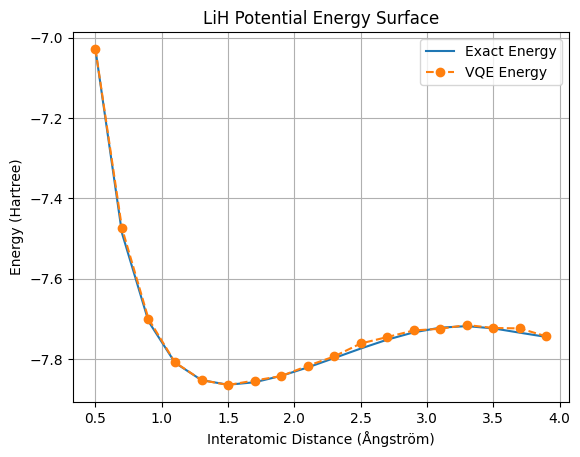

In [14]:
# The FIX is to use 'distances' for the x-axis, NOT a new np.arange().
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, 'o--', label="VQE Energy")

# Add labels and a title for a publication-quality plot
plt.xlabel('Interatomic Distance (Ångström)')
plt.ylabel('Energy (Hartree)')
plt.title('LiH Potential Energy Surface')
plt.legend()
plt.grid(True)
plt.show()

--- Testing SPSA Optimizer ---
HF energy: -7.861864769808652
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy Error: 0.003102
--- Testing SLSQP Optimizer ---
HF energy: -7.861864769808652
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy Error: 0.247104
--- Testing COBYLA Optimizer ---
HF energy: -7.86186476980865
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy Error: 0.000708
--- Testing L_BFGS_B Optimizer ---
HF energy: -7.86186476980865
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy Error: 0.151921


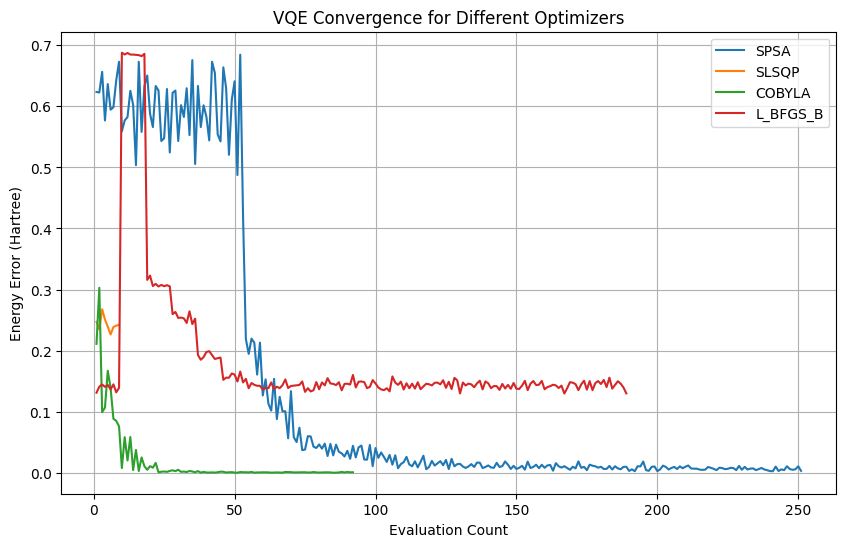

In [15]:
# Use a list for consistent ordering
optimizer_list = ['SPSA', 'SLSQP', 'COBYLA', 'L_BFGS_B']
map_type = 'parity'
distance = 1.6 # A fixed distance for the comparison

plt.figure(figsize=(10, 6))

for opt_name in optimizer_list:
    print(f"--- Testing {opt_name} Optimizer ---")
    
    # Get the problem description
    qubit_op, problem, mapper, shift = compute_LiH_qubitOp(map_type, distance)
    
    # Get the exact classical reference energy
    ref_value = exact_solver(qubit_op) + shift

    # Prepare lists to store callback data for this optimizer
    counts = []
    values = []

    # Set up the ansatz
    ansatz = EfficientSU2(qubit_op.num_qubits, reps=1, entanglement='linear')

    # Choose the classical optimizer
    if opt_name == 'SPSA':
        optimizer = SPSA(maxiter=100)
    elif opt_name == 'SLSQP':
        optimizer = SLSQP(maxiter=1000)
    elif opt_name == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=1000)
    elif opt_name == 'COBYLA':
        optimizer = COBYLA(maxiter=1000)
        
    # Set up the modern VQE algorithm
    estimator = Estimator(backend_options={"method": "statevector"})
    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)

    # Run VQE and get the final result
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    final_energy = result.eigenvalue + shift
    
    # Print the final error
    final_error = abs(ref_value - final_energy)
    print(f"Final Energy Error: {final_error:.6f}")

    # Calculate and plot the energy error at each step of the optimization
    energy_error = np.abs(ref_value - (np.array(values) + shift))
    plt.plot(counts, energy_error, label=opt_name)

# Final plotting commands
plt.xlabel('Evaluation Count')
plt.ylabel('Energy Error (Hartree)')
plt.title('VQE Convergence for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
ansatz_configs = [
    #{'name': 'UCCSD', 'class': UCCSD},
    {'name': 'EfficientSU2', 'class': EfficientSU2} 
]

optimizer_classes = [SPSA, SLSQP, COBYLA, L_BFGS_B]
opt_max_eval = 200
inter_dist = 1.6 # Use a fixed distance for this experiment
results_dict = {} 
# --- 2. Loop through all combinations ---

for ansatz_config in ansatz_configs:
    for opt_class in optimizer_classes:
        
        ansatz_name = ansatz_config['name']
        opt_name = opt_class.__name__
        run_name = f"{ansatz_name}_{opt_name}"
        
        print(f"--- Running: {run_name} ---")

        # a. Get the problem description
        qubit_op, problem, mapper, shift = compute_LiH_qubitOp('parity', inter_dist)
        
        # b. Get the exact classical reference energy
        ref_value = exact_solver(qubit_op) + shift

        # c. Set up the ansatz correctly based on its type
        ansatz_class = ansatz_config['class']
       
        ansatz = EfficientSU2(qubit_op.num_qubits, reps=1, entanglement='linear')

        # d. Set up the optimizer and Estimator
        optimizer = opt_class(maxiter=opt_max_eval)
        estimator = Estimator(backend_options={"method": "statevector"})
        
        # e. Use the SAME manual VQE workflow for both ansatze
        vqe = VQE(estimator, ansatz, optimizer)
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        final_energy = result.eigenvalue + shift
        
        # f. Print and store the results
        final_error = abs(ref_value - final_energy)
        results_dict[run_name] = final_error
        
        print(f"Final Energy: {final_energy:.6f}")
        print(f"Reference Energy: {ref_value:.6f}")
        print(f"Final Energy Error: {final_error:.6f}\n")

# --- 3. Print a final summary ---
print("--- Final Error Summary ---")
for name, error in results_dict.items():
    print(f"{name}: {error:.6f}")

--- Running: EfficientSU2_SPSA ---
HF energy: -7.86186476980865
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy: -7.862000
Reference Energy: -7.862129
Final Energy Error: 0.000129

--- Running: EfficientSU2_SLSQP ---
HF energy: -7.86186476980865
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy: -7.334966
Reference Energy: -7.862129
Final Energy Error: 0.527162

--- Running: EfficientSU2_COBYLA ---
HF energy: -7.861864769808654
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy: -7.860290
Reference Energy: -7.862129
Final Energy Error: 0.001839

--- Running: EfficientSU2_L_BFGS_B ---
HF energy: -7.861864769808652
# of electrons: (2, 2)
# of spin orbitals: 12
Reference value: -1.058117
Final Energy: -7.660227
Reference Energy: -7.862129
Final Energy Error: 0.201902

--- Final Error Summary ---
EfficientSU2_SPSA: 0.000129
EfficientSU2_SLSQP: 0.527162
EfficientSU2_COBYLA: 0.001839
